In [1]:
import pandas as pd 
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load model path into logic_ensemble object

In [2]:
model_path = '/home/spankaew/Git/astrologics/models/dev/synthetic_random_diff/'
model = le.LogicEnsemble(model_path, project_name = 'synthetic_random_diff')
model.create_simulation()

Simulation object created


# Create simulation trajectory from the simulation
When we perform the simulation, the result of the timestep node activity can be visualized using dimension reduction method such as `pca`.

In [3]:
test = pd.read_csv(model_path + '/bn_0.bnet', sep = ',', header = None)
test[1] = 0.5
test_dict = dict(zip(test[0], test[1]))
test_dict

{'x0': 0.5,
 'x1': 0.5,
 'x10': 0.5,
 'x11': 0.5,
 'x12': 0.5,
 'x13': 0.5,
 'x14': 0.5,
 'x15': 0.5,
 'x17': 0.5,
 'x2': 0.5,
 'x20': 0.5,
 'x21': 0.5,
 'x23': 0.5,
 'x24': 0.5,
 'x26': 0.5,
 'x3': 0.5,
 'x4': 0.5,
 'x6': 0.5,
 'x8': 0.5,
 'x9': 0.5}

In [4]:
model.simulation.update_parameters(max_time = 10, sample_count = 3000)
model.simulation.run_simulation(initial_state=test_dict)

Start simulation


100%|██████████| 1000/1000 [08:22<00:00,  1.99it/s]


Simulation completed


In [6]:
save_path = '/home/spankaew/Git/astrologics/models/'
model.simulation.simulation_df.to_csv(save_path + 'srd_simulation.csv')

In [35]:
save_path = '/home/spankaew/Git/astrologics/models/'
model.simulation.simulation_df = pd.read_csv(save_path + 'srd_simulation.csv', index_col = 0)

Trajectory object created


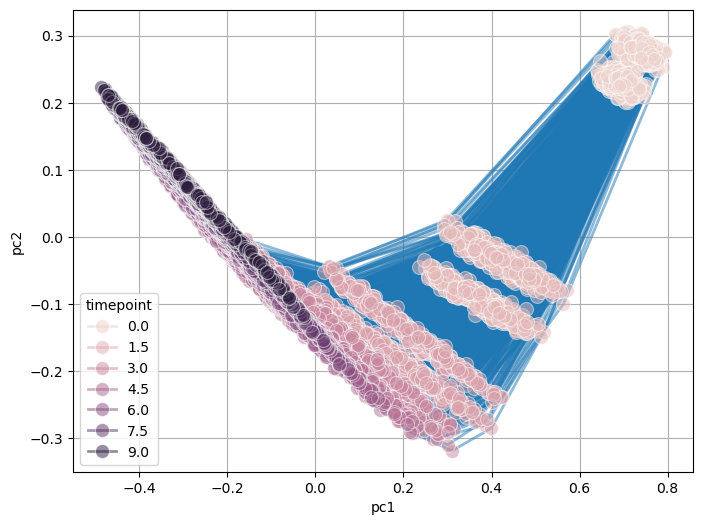

In [36]:
model.create_trajectory()
model.trajectory.pca_trajectory()
model.trajectory.plot_trajectory(color = 'timepoint', show_legend=True)

From the visualization, we can then try to group together models with simular simulation activity via clustering. 

In `logic_ensemble`, we utilize the package called `tslearn` - a toolkit to perform analysis on time series data. 

The timeseries clustering method included in this toolkit includes : 

- euclidean

- dynamic time warping (dtw) 

- softdtw.

The calculated clustering will be embeded into the trajectory matrix

In [37]:
simulation_df = model.simulation.simulation_df
simulation_df.model_id = simulation_df.model_id.astype('category')
node_list = simulation_df.columns.drop(['timepoint','model_id'])
model_name = simulation_df.model_id.cat.categories

model_original_all = {}
for i in model_name:
    model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
simulation_df_all = np.array(list(model_original_all.values()))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:48<00:00, 20.57it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hi

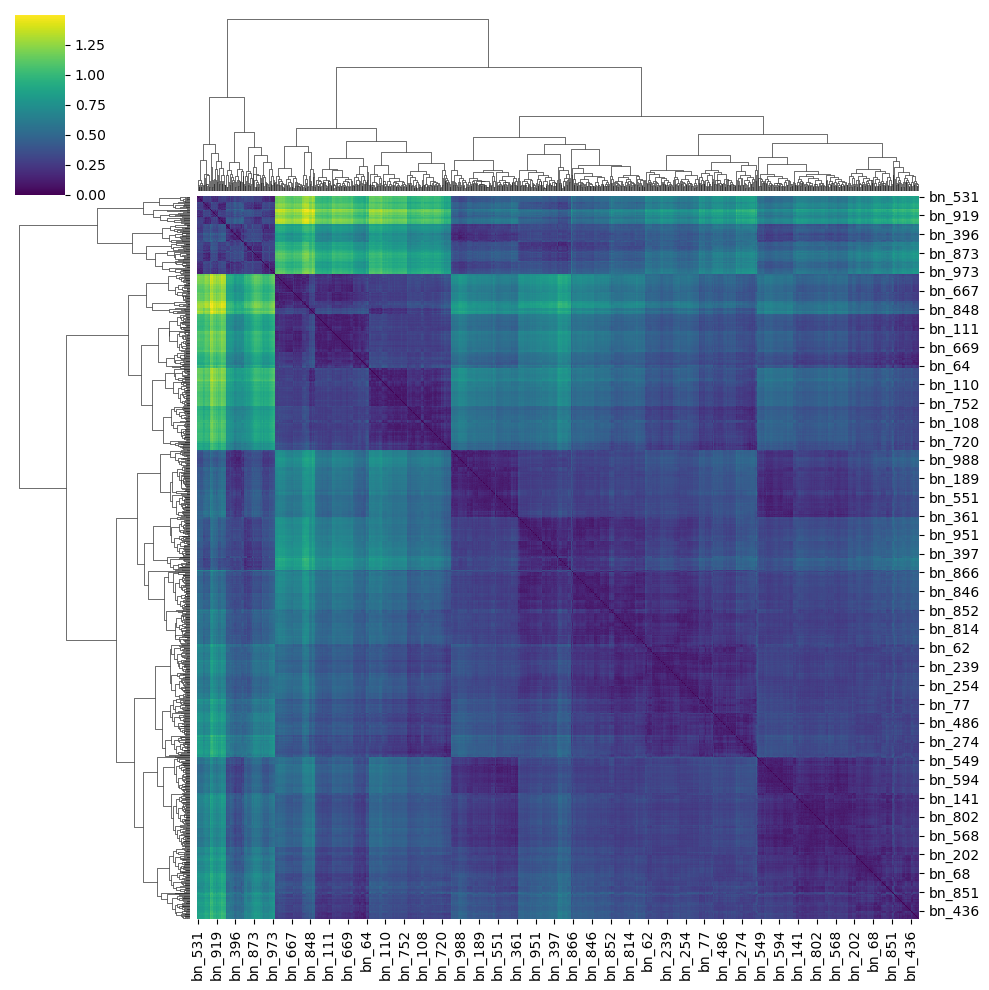

In [38]:
from tslearn.metrics import dtw
from tqdm import tqdm

# Initialize an empty distance matrix
num_trajectories = len(simulation_df_all)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in tqdm(range(num_trajectories)):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(simulation_df_all[i], simulation_df_all[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)
sns.clustermap(distance_matrix, cmap='viridis', figsize=(10,10))

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


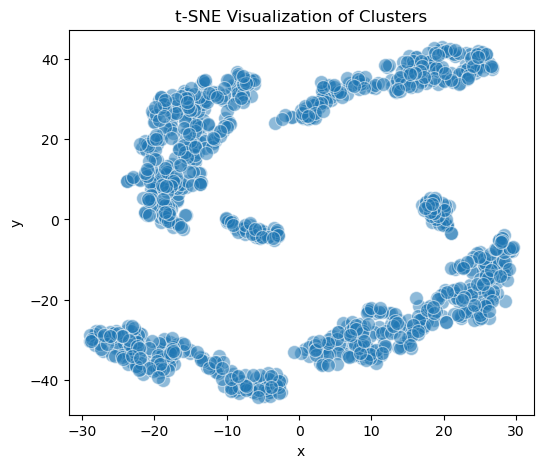

In [70]:
from sklearn.manifold import TSNE

# Visualize clusters with t-SNE
tsne = TSNE(metric='precomputed', random_state=123, perplexity=30, n_iter=1000, init='random')
coords = tsne.fit_transform(distance_matrix)
coords_vis = pd.DataFrame(coords, columns=['x', 'y'], index=distance_matrix.index)

# Plot the t-SNE visualization
plt.figure(figsize=(6, 5))
sns.scatterplot(data=coords_vis, x='x', y='y', alpha=0.5, s=100)
plt.title('t-SNE Visualization of Clusters')
plt.show()

In [39]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state= 123)
coords = mds.fit_transform(distance_matrix)
coords_vis = pd.DataFrame(coords, columns = ['x', 'y'], index = distance_matrix.index)

/tmp/ipykernel_214281/3749525524.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


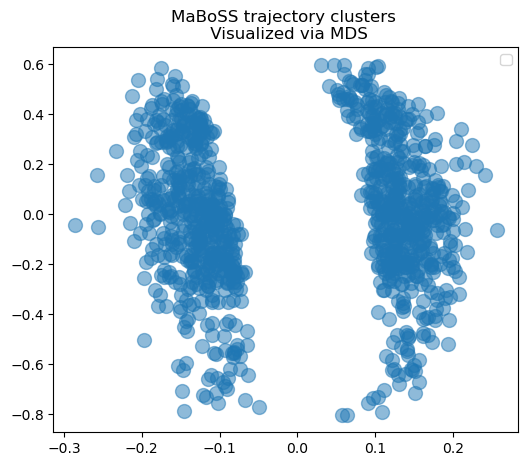

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/srd_trajMDS_v2.pdf')

plt.show()
plt.close()

In [53]:
coords_vis['manual_clust'] = coords_vis['x']>0
coords_vis['manual_clust'] = coords_vis['manual_clust'].astype('category')

In [41]:
# Get traj cluster
model.trajectory.calculate_kmean_cluster(n_cluster=2, data = 'original', metric = 'dtw')
cluster_dict_df = pd.DataFrame(list(model.trajectory.cluster_dict.items()), columns=['Model', 'traj_cluster'])
cluster_dict_df.set_index('Model', inplace=True)

coords_vis = pd.DataFrame(coords, columns = ['x', 'y'], index = distance_matrix.index)
coords_vis = pd.concat([coords_vis, cluster_dict_df],axis = 1)

DTW k-means


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1

0.098 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.055 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.054 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.054 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.054 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.054 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.054 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.054 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s


0.054 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace 

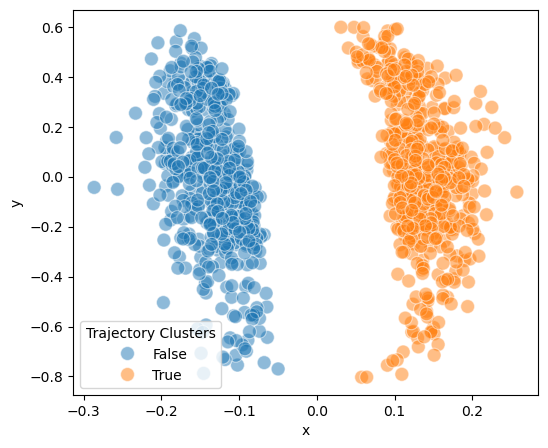

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=coords_vis, x='x', y='y', hue='manual_clust', palette='tab10', alpha=0.5, s=100)
plt.legend(title='Trajectory Clusters')

plt.show()
plt.close()


In [59]:
manual_clust_dict = coords_vis['manual_clust'].replace({True: 1, False: 0}).to_dict()
model.trajectory.cluster_dict= manual_clust_dict

/tmp/ipykernel_214281/1794424339.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  manual_clust_dict = coords_vis['manual_clust'].replace({True: 1, False: 0}).to_dict()
/tmp/ipykernel_214281/1794424339.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  manual_clust_dict = coords_vis['manual_clust'].replace({True: 1, False: 0}).to_dict()


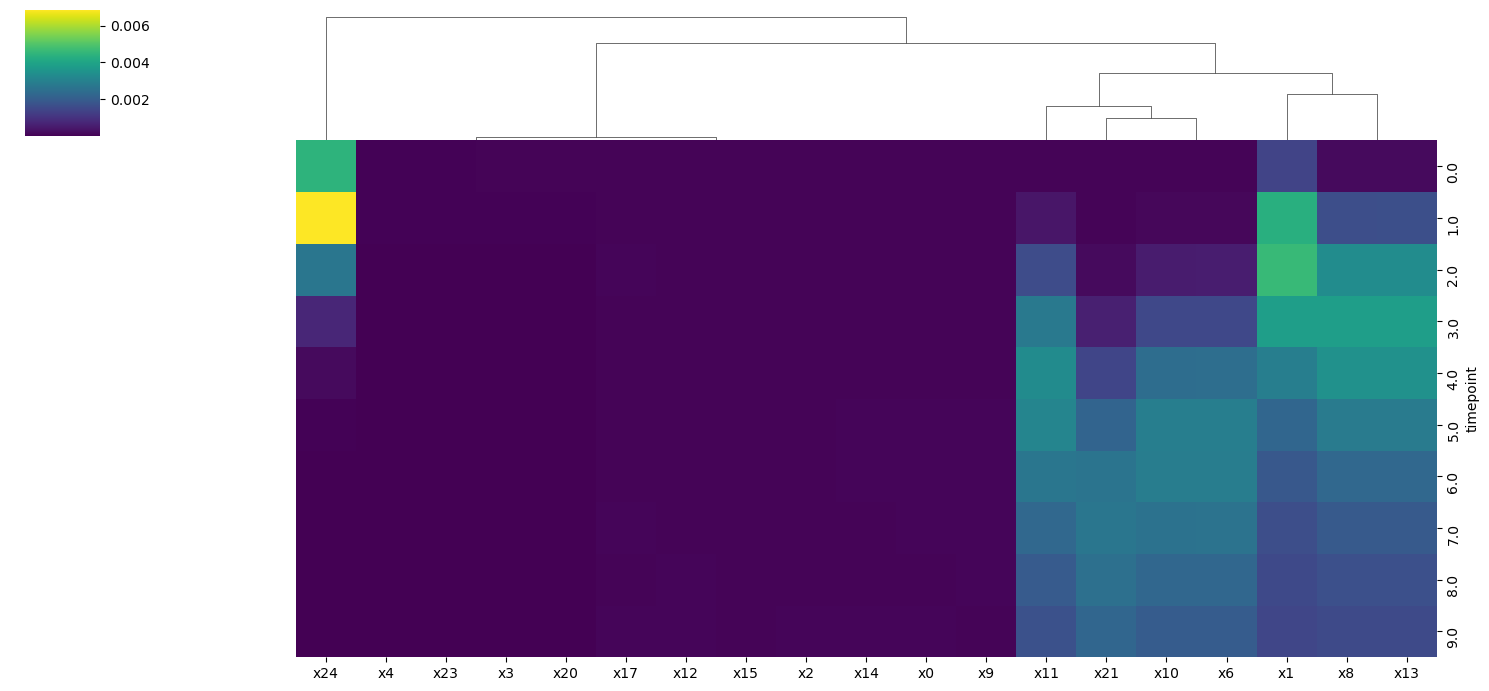

In [60]:
import pandas as pd

# Assuming `model_mtx` is your DataFrame with genes as columns and 'timepoint' as one of the columns
model_mtx = model.trajectory.simulation_df

# Group by 'timepoint' and calculate variance for each gene
variance_results = model_mtx.groupby('timepoint')[model_mtx.columns[:-3]].var()
variance_results['avg'] = variance_results.mean(axis = 1)
sns.clustermap(variance_results.drop(columns = ['avg']), row_cluster=False, cmap = 'viridis', figsize = (15,7))

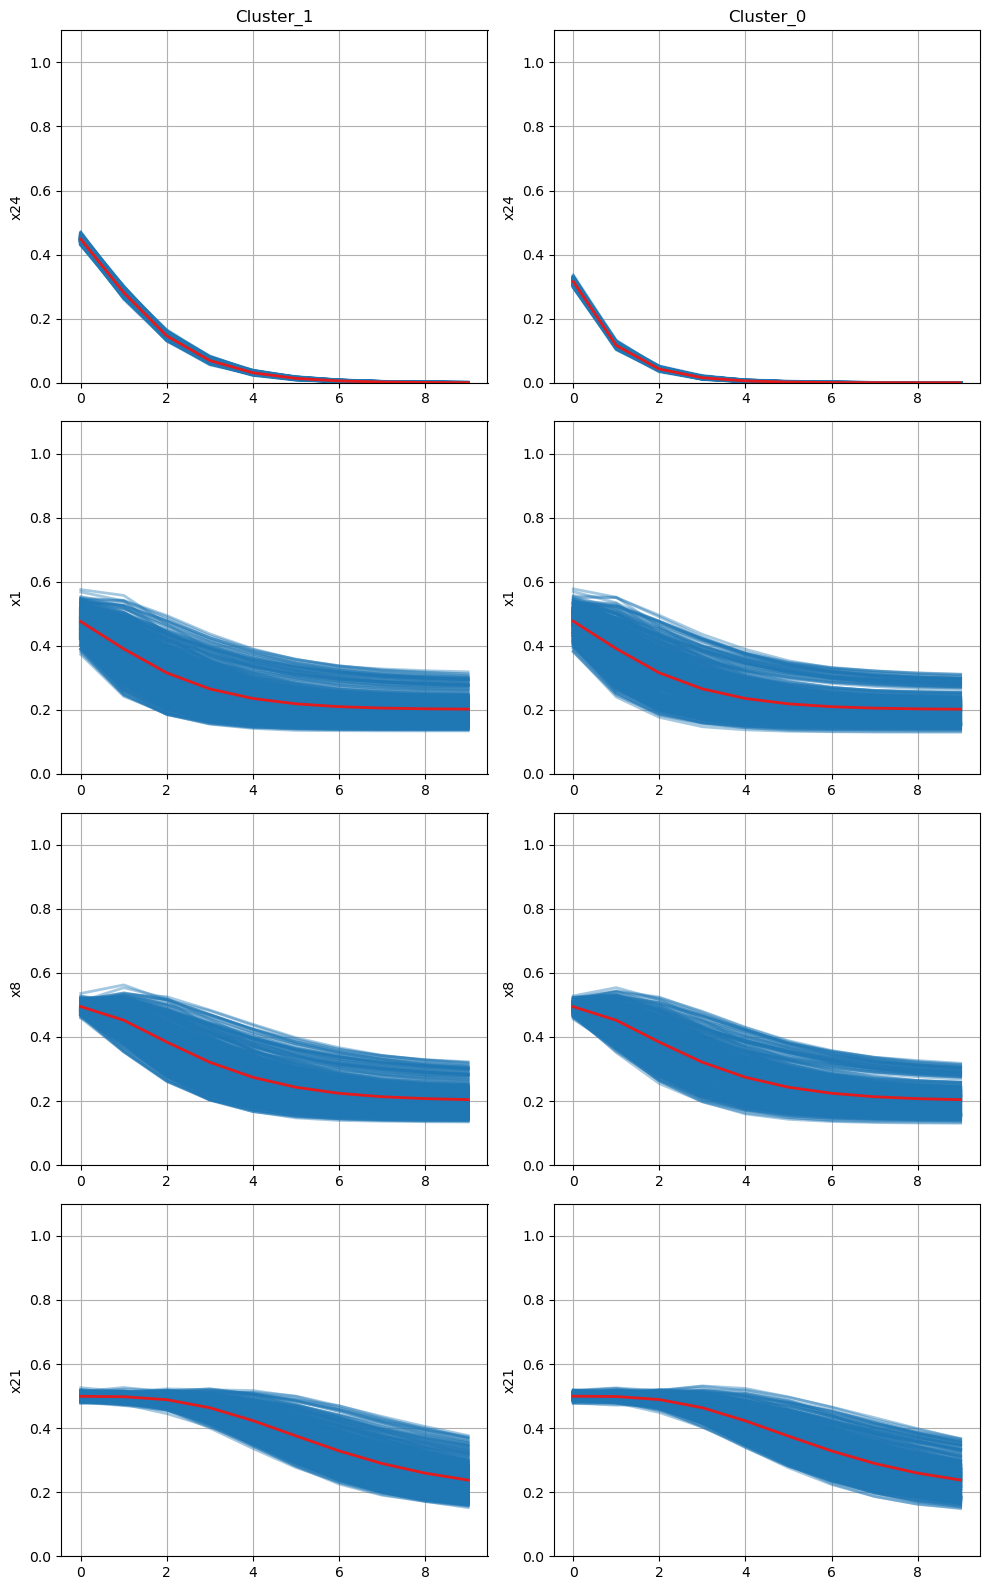

In [61]:
# Setup the gene list
selected_genes = ['x24', 'x1','x8','x21']
num_timesteps = 20
model_mtx['type'] = model_mtx['model_id'].map(model.trajectory.cluster_dict)
cluster_type = list(model_mtx.type.unique())

# Function to create matrix for each condition
def create_vis_matrix(cluster_type):
    vis = model_mtx.loc[model_mtx['type'] == cluster_type]
    vis = vis[selected_genes + ['timepoint', 'model_id']]
    vis = vis[vis.timepoint.isin(range(0, num_timesteps))]
    vis['model_id'] = vis['model_id'].astype('str')
    vis['type'] = cluster_type
    return vis

# Create matrices for each condition
vis_matrices = [create_vis_matrix(i) for i in cluster_type]

# Plot with Seaborn
plt.figure(figsize=(len(cluster_type) * 5, len(selected_genes) * 4))
n_genes = len(selected_genes)

for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, len(cluster_type), len(cluster_type) * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, 
                            units = 'model_id', estimator = None, alpha = 0.4)
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.set_xlabel(None)
        plot.grid(True)
        if i == 0:
            plot.set_title(f'Cluster_{cluster_type[j]}')
            
for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, len(cluster_type), len(cluster_type) * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, hue = 'type',palette='Set1')
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.grid(True)
        plot.set_xlabel(None)
        plot.legend().remove()

plt.tight_layout()
plt.show()
plt.close()

# Create logic function matrix
In this part of the script, we load models' logic function into a matrix. This matrix can then be transformed into a Disjunctive Normal Form (DNF) which allow us to identify clause of components that can activate each node. 

Loading models logics


100%|██████████| 1000/1000 [00:01<00:00, 771.30it/s]


Concatenate results into matrix


100%|██████████| 1000/1000 [00:01<00:00, 962.65it/s]

Logic object created
Flatten models logic clauses



100%|██████████| 1000/1000 [00:00<00:00, 2273335.50it/s]


Concatenate results into matrix


100%|██████████| 1000/1000 [00:00<00:00, 1443.56it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Flattend logic clause created


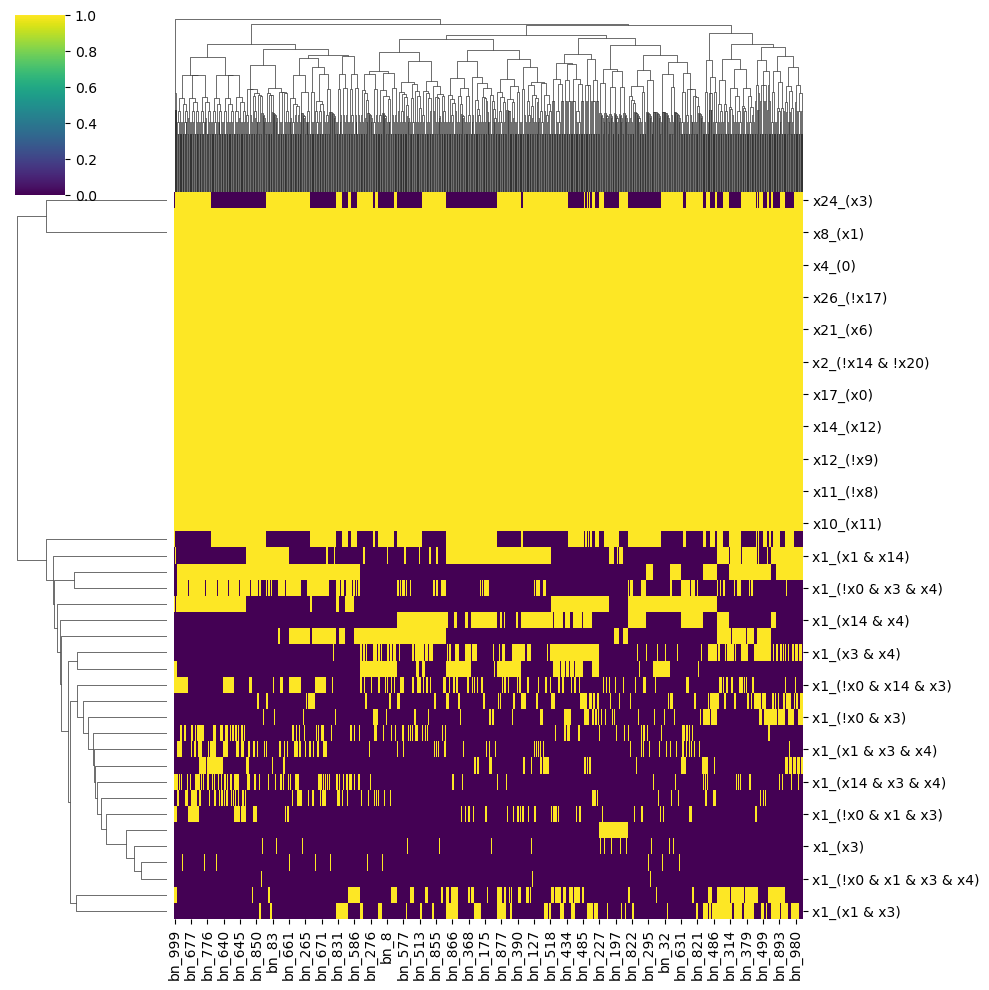

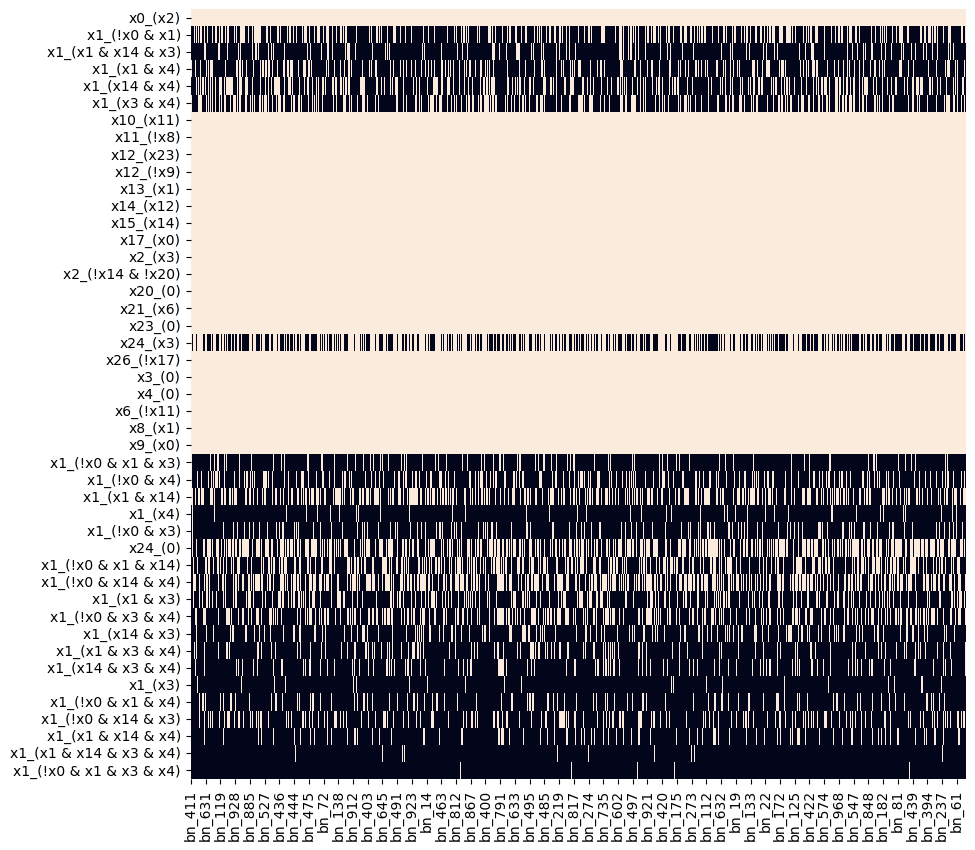

In [63]:
model.create_logic()
model.logic.create_flattend_logic_clause()
# Create the clustermap
clustermap = sns.clustermap(model.logic.logic_clause_flattend, 
                            cmap='viridis', vmax=1, vmin=0, figsize=(10,10))

# Get the row and column order from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Reorder the dataframe
reordered_df = model.logic.logic_clause_flattend.iloc[row_order, col_order]
# Plot the heatmap with the reordered dataframe without color bar
plt.figure(figsize=(10,10))
sns.heatmap(model.logic.logic_clause_flattend, vmax=1, vmin=0, cbar=False)
#plt.savefig('/home/spankaew/Git/astrologics/figures/toy_reprogramming_Logic.pdf')
plt.show()
plt.close()

In [64]:
from sklearn.preprocessing import OrdinalEncoder
model_cluster = pd.Series(model.trajectory.cluster_dict)
model_logic = model.logic.model_logic

var_logic_clust = pd.DataFrame()
for i in list(model_cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.unique())

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

In [65]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(model.trajectory.cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create a dictionary to store features and their groups
feature_groups = {
    'Feature': constant_features + varied_features + marker_features,
    'Group': (['Constant'] * len(constant_features)) +
             (['Varied'] * len(varied_features)) +
             (['Marker'] * len(marker_features))
}

# Convert the dictionary to a DataFrame
features_df = pd.DataFrame(feature_groups)

# Add the node features into the DataFrame
features_df['Node'] = features_df['Feature'].str.split('_', n=1, expand=True)[0]

/tmp/ipykernel_214281/4030930402.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_var_logic_length.index,
/tmp/ipykernel_214281/4030930402.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=sorted_var_logic_length.index,


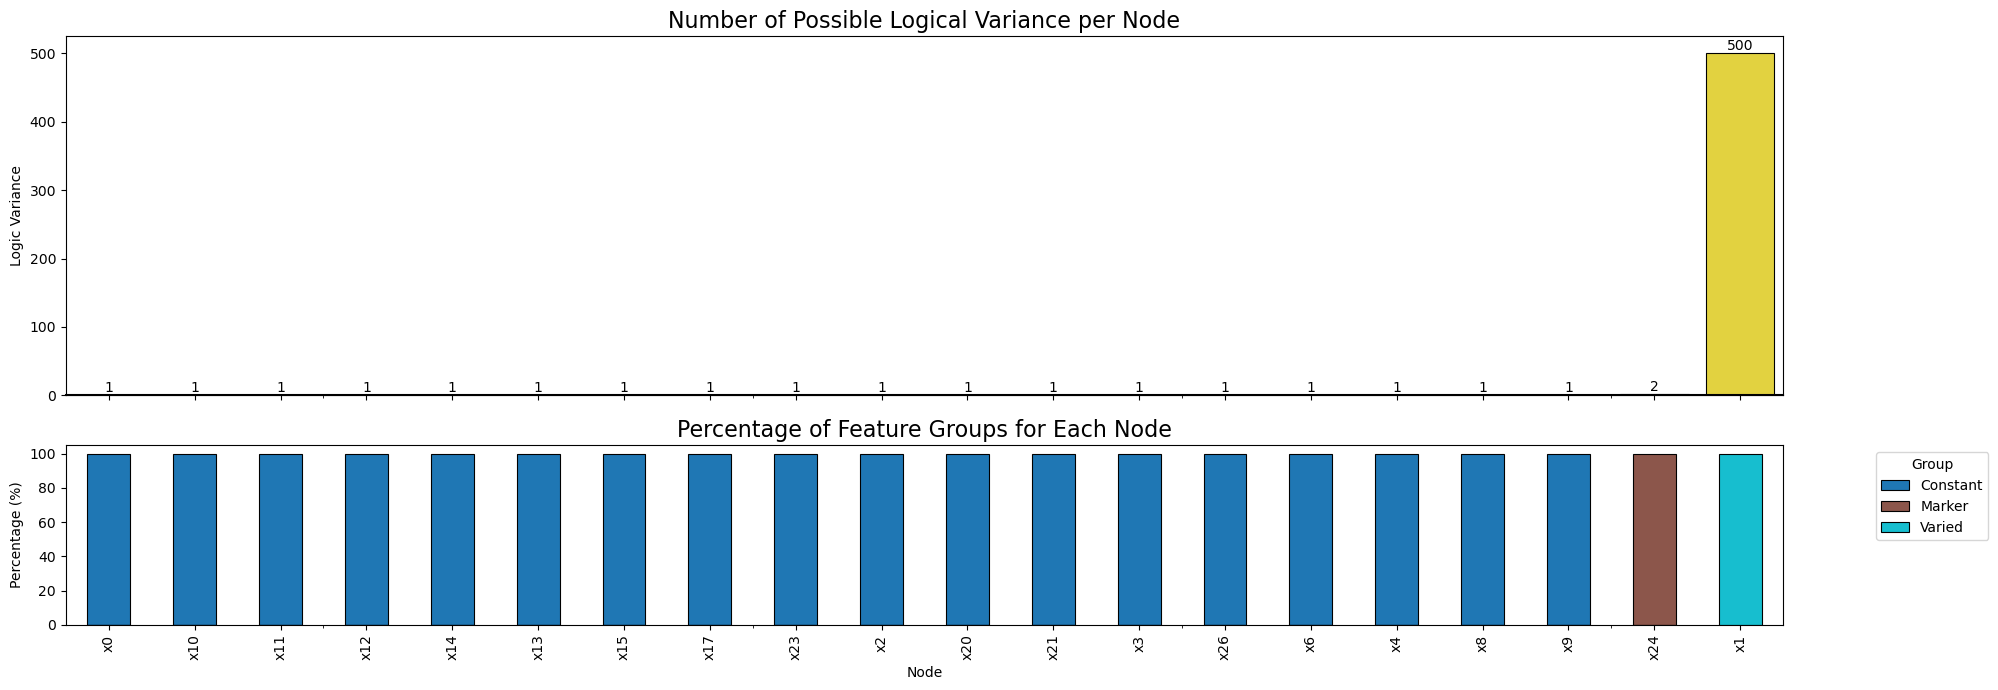

In [66]:
# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the first barplot
sorted_var_logic_length = encoded_df.max().sort_values() + 1
sns.barplot(x=sorted_var_logic_length.index, 
            y=sorted_var_logic_length.values, 
            palette=sns.color_palette("viridis", as_cmap=True)(sorted_var_logic_length.values / sorted_var_logic_length.max()), 
            edgecolor='black', linewidth=0.8, ax=axes[0])

# Customize the first plot
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel('Logic Variance')
axes[0].set_title('Number of Possible Logical Variance per Node', fontsize=16)
axes[0].tick_params(axis='x', rotation=90)
for index, value in enumerate(sorted_var_logic_length.astype('int')):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Plot the second stacked barplot
features_df_grouped = features_df.groupby(['Node', 'Group']).size().unstack(fill_value=0)
features_df_grouped = features_df_grouped.loc[sorted_var_logic_length.index]
features_df_percentage = features_df_grouped.div(features_df_grouped.sum(axis=1), axis=0) * 100
features_df_percentage.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1], edgecolor='black', linewidth=0.8)

# Customize the second plot
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Node')
axes[1].set_title('Percentage of Feature Groups for Each Node', fontsize=16)
axes[1].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


In [67]:
features_df.loc[(features_df['Node'] == 'x24') & (features_df['Group'] == 'Marker')].Feature

43    x24_(x3)
44     x24_(0)
Name: Feature, dtype: object

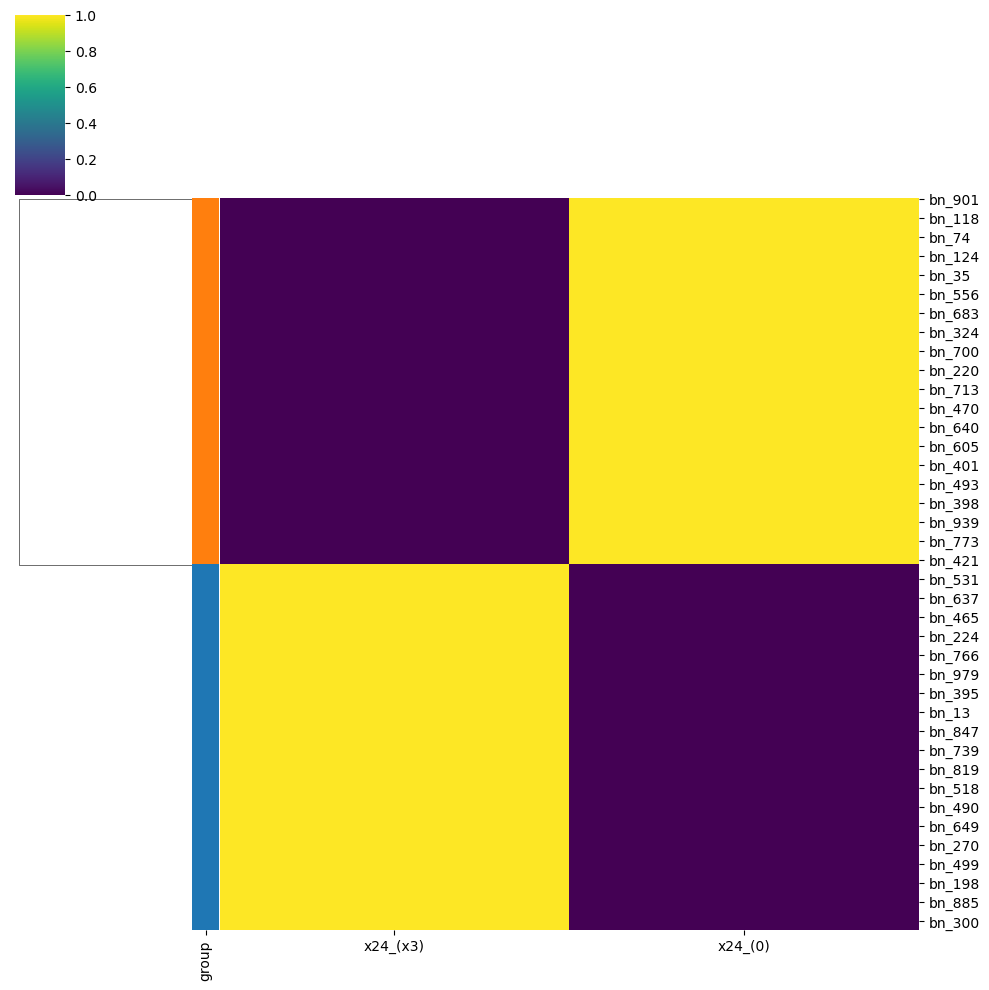

In [68]:
selected_features = features_df.loc[(features_df['Node'] == 'x24') & (features_df['Group'] == 'Marker')].Feature

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create the clustermap with row colors
sns.clustermap(test[selected_features], col_cluster = False, row_cluster = True,
               cmap='viridis', figsize=(10, 10), row_colors=group_colors)